# Tennessee Counties, Population, and Earthquakes

In [28]:
#conda activate Geospatial (in terminal)
import requests
import pandas as pd
from io import StringIO
import json 
import csv 
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import math

# 1. Reading in and Cleaning up Data Sets

In [2]:
# capture data within the tn boarders with longitude and latitude and convert to csv and start the time from 1900 to now
url = 'https://opendata.arcgis.com/datasets/592082987bd5456baab74d70f1bf5d90_0.geojson'

In [3]:
#getting API url and building df
r = requests.get(url)
tn_counties = gpd.read_file(url)

In [4]:
# cleaning to just needed columns
tn_counties['county'] = tn_counties['NAMELSAD']
tn_counties = tn_counties[['county','Population','geometry']]

In [5]:
#bring in geometry of big quakes
outside_tn_quake_df = pd.read_csv('../data/cleaned_outside_tn_earthquake_data.csv')

#subsetting for quakes larger than 3.8 magnitude
big_quakes = outside_tn_quake_df[outside_tn_quake_df['mag']>3.8]

# getting rid of quakes too far from tn border
big_quakes = big_quakes[big_quakes['Unnamed: 0'].isin([10204, 10228, 10229, 10209, 335, 6013, 7003,9884]) == False]

#sorting quakes df by magnitude
big_quakes = big_quakes.sort_values(by = 'mag')

In [6]:
#creating a geometry column
big_quakes['geometry'] = big_quakes.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis = 1)

In [8]:
#creating a GeoDataFrame
big_quakes = gpd.GeoDataFrame(big_quakes, geometry = big_quakes['geometry'])

# 2. Population Map of Tn by County

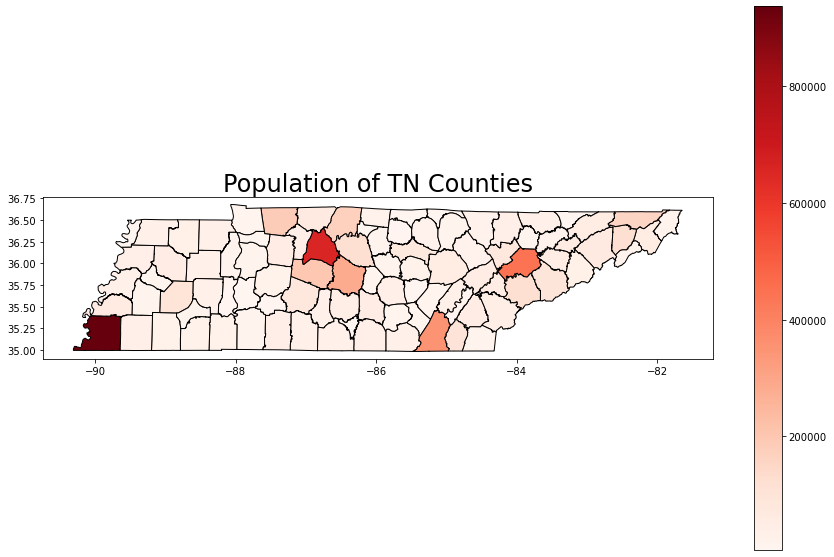

In [36]:
#creating map of population in TN
tn_counties.plot(column = 'Population', figsize=(15, 10),
              edgecolor = 'black',legend = True, cmap = 'Reds')
plt.title('Population of TN Counties', fontsize=24, ha='center')
plt.show()

# 3. Map of Big Earthquakes in and Around TN

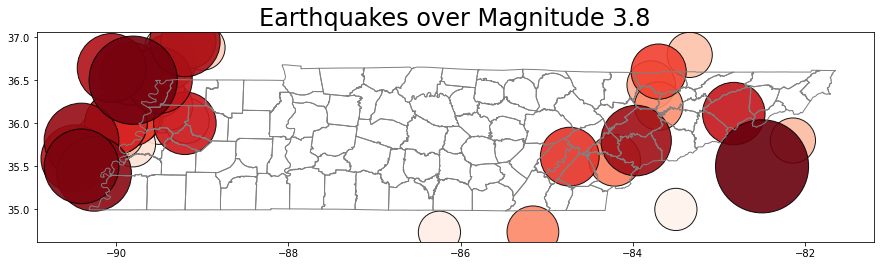

In [37]:
#Plotting Earthquakes on TN Counties (Circles sized and colored by magnitude)
ax = tn_counties['geometry'].boundary.plot(figsize = (15,10), color = 'Gray', linewidth=1)
big_quakes['geometry'].plot(ax = ax, markersize = big_quakes['mag'] ** 5.5, cmap = 'Reds', alpha = 0.9, edgecolor = 'black')
plt.title('Earthquakes over Magnitude 3.8', fontsize=24, ha='center')
plt.show();

# 4. Calculating County Risk of Large Earthquake and Risk of Damage

In [16]:
#initializing lists for estimated percent covered
p_100 = ['Lake County', 'Dyer County', 'Crockett County', 'Claiborne County', 'Union County', 'Greene County', 'Knox County', 'Blount County', 'Meigs County']
p_75 = ['Gibson County', 'Rhea County', 'McMinn County']
p_50 = ['Obion County', 'Lauderdale County', 'Grainger County', 'Cocke County', 'Loudon County', 'Roane County', 'Anderson County']
p_25 = ['Tipton County', 'Shelby County', 'Haywood County', 'Unicol County', 'Monroe County', 'Sevier County', 'Jefferson County']

In [17]:
#creating estimated percent covered column
tn_counties['est_percent_covered'] = 0

In [18]:
#filling in correct estimates
for index, row in tn_counties.iterrows():
    if row['county'] in p_100:
        tn_counties['est_percent_covered'][index] = 100
    elif row['county'] in p_75:
        tn_counties['est_percent_covered'][index] = 75
    elif row['county'] in p_50:
        tn_counties['est_percent_covered'][index] = 50
    elif row['county'] in p_25:
        tn_counties['est_percent_covered'][index] = 25

<ipython-input-18-8a9aceea209d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['est_percent_covered'][index] = 50
<ipython-input-18-8a9aceea209d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['est_percent_covered'][index] = 100
<ipython-input-18-8a9aceea209d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['est_percent_covered'][index] = 75
<ipython-input-18-8a9aceea209d>:10: SettingWithCopyWar

In [19]:
#initiating mag column
tn_counties['mag'] = 0.0

#initiating affected_people column
tn_counties['affected_people'] = tn_counties['Population'] * (tn_counties['est_percent_covered']/100)

In [20]:
#correct mag column above
m_4_1 = ['Lauderdale County', 'Union County', 'Grainger County','Jefferson County']
m_4_3 = ['Obion County', 'Claiborne County', 'Monroe County']
m_4_4 = ['Roane County', 'Rhea County', 'Meigs County', 'McMinn County']
m_4_5 = ['Dyer County', 'Gibson County', 'Crockett County', 'Haywood County', 'Greene County', 'Cocke County', 'Unicol County']
m_4_7 = ['Sevier County', 'Knox County', 'Blount County', 'Loudon County', 'Anderson County']
m_4_8 = ['Tipton County', 'Shelby County']
m_5_1 = ['Lake County']

In [21]:
#filling in correct magnitudes
for index, row in tn_counties.iterrows():
    if row['county'] in m_4_1:
        tn_counties['mag'][index] = 4.1
    elif row['county'] in m_4_3:
        tn_counties['mag'][index] = 4.3
    elif row['county'] in m_4_4:
        tn_counties['mag'][index] = 4.4
    elif row['county'] in m_4_5:
        tn_counties['mag'][index] = 4.5
    elif row['county'] in m_4_7:
        tn_counties['mag'][index] = 4.7
    elif row['county'] in m_4_8:
        tn_counties['mag'][index] = 4.8
    elif row['county'] in m_5_1:
        tn_counties['mag'][index] = 5.1

<ipython-input-21-066316ee2a70>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['mag'][index] = 4.7
<ipython-input-21-066316ee2a70>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['mag'][index] = 4.3
<ipython-input-21-066316ee2a70>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['mag'][index] = 4.5
<ipython-input-21-066316ee2a70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [22]:
#making strength and risk number columns
tn_counties['strength'] = 2 ** (tn_counties['mag']) 
tn_counties['county_risk_number'] = (tn_counties['affected_people'] * tn_counties['strength'])**(1/5)

In [23]:
# Putting in order by county's risk
tn_counties = tn_counties.sort_values(by = 'county_risk_number', ascending = False)

## 5. Counties colored by risk of big earthquake (strength)

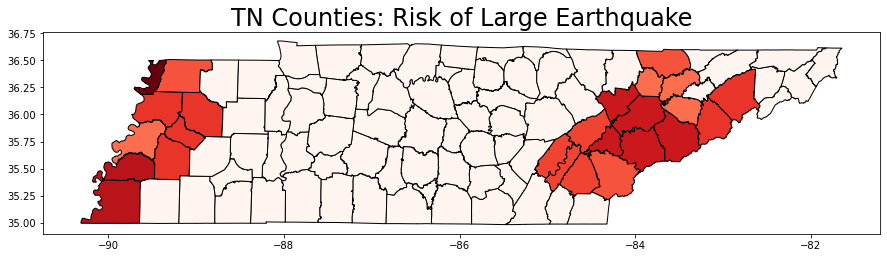

In [38]:
#creating map of population in TN
tn_counties.plot(column = 'strength', figsize=(15, 10),
              edgecolor = 'black', cmap = 'Reds')
plt.title('TN Counties: Risk of Large Earthquake', fontsize=24, ha='center')
plt.show()

In [25]:
#showing top 10
tn_counties.sort_values(by = 'strength').tail(10)

,county,Population,geometry,est_percent_covered,mag,affected_people,strength,county_risk_number
26,Gibson County,49572,"POLYGON ((-89.20630 36.01182, -89.20625 36.011...",75,4.5,37179.00,22.627417,15.310400
22,Dyer County,38054,"POLYGON ((-89.59777 36.18599, -89.59753 36.186...",100,4.5,38054.00,22.627417,15.381796
4,Blount County,125188,"POLYGON ((-84.14252 35.79696, -84.14158 35.797...",100,4.7,125188.00,25.992077,20.066921
0,Anderson County,75430,"POLYGON ((-84.33465 36.03021, -84.33470 36.030...",50,4.7,37715.00,25.992077,15.785961
52,Loudon County,50229,"MULTIPOLYGON (((-84.54036 35.61938, -84.54036 ...",50,4.7,25114.50,25.992077,14.553019
77,Sevier County,93617,"POLYGON ((-83.78438 35.87617, -83.78439 35.876...",25,4.7,23404.25,25.992077,14.349182
46,Knox County,444348,"POLYGON ((-84.07291 36.04973, -84.07303 36.049...",100,4.7,444348.00,25.992077,25.853113
83,Tipton County,61674,"MULTIPOLYGON (((-90.17835 35.38210, -90.17927 ...",25,4.8,15418.50,27.857618,13.384348
78,Shelby County,937750,"POLYGON ((-90.07434 35.21102, -90.07409 35.212...",25,4.8,234437.50,27.857618,23.067164
47,Lake County,7687,"POLYGON ((-89.50960 36.37475, -89.50959 36.374...",100,5.1,7687.00,34.296751,12.139533


## Top 10 Counties by Risk of Large Quake
### 1. Lake           
### 2. Shelby     
### 3. Tipton      
### 4. Knox      
### 5. Sevier   
### 6. Loudon
### 7. Anderson
### 8. Blount
### 9. Dyer
### 10. Gibson

## 6. Counties colored by risk of damage (county_risk_number)

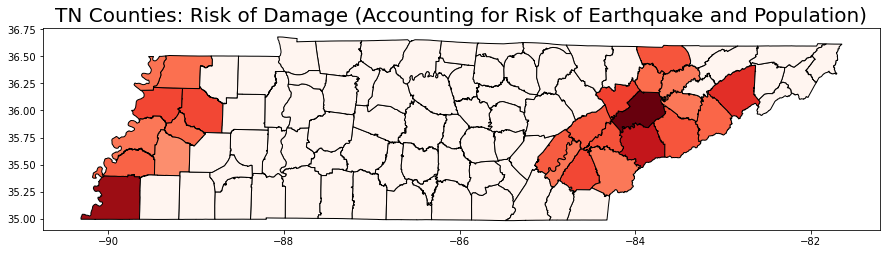

In [40]:
#creating map of population in TN
tn_counties.plot(column = 'county_risk_number', figsize=(15, 10),
              edgecolor = 'black', cmap = 'Reds')
plt.title('TN Counties: Risk of Damage (Accounting for Risk of Earthquake and Population)', fontsize=20, ha='center')
plt.show()

In [27]:
#showing top 10
tn_counties.sort_values(by = 'county_risk_number').tail(10)

,county,Population,geometry,est_percent_covered,mag,affected_people,strength,county_risk_number
12,Claiborne County,31748,"POLYGON ((-83.64973 36.60013, -83.64559 36.600...",100,4.3,31748.0,19.698311,14.428762
52,Loudon County,50229,"MULTIPOLYGON (((-84.54036 35.61938, -84.54036 ...",50,4.7,25114.5,25.992077,14.553019
53,McMinn County,52506,"POLYGON ((-84.73652 35.51632, -84.73559 35.517...",75,4.4,39379.5,21.112127,15.274269
26,Gibson County,49572,"POLYGON ((-89.20630 36.01182, -89.20625 36.011...",75,4.5,37179.0,22.627417,15.310400
22,Dyer County,38054,"POLYGON ((-89.59777 36.18599, -89.59753 36.186...",100,4.5,38054.0,22.627417,15.381796
0,Anderson County,75430,"POLYGON ((-84.33465 36.03021, -84.33470 36.030...",50,4.7,37715.0,25.992077,15.785961
29,Greene County,68576,"POLYGON ((-83.02149 36.26970, -83.02139 36.269...",100,4.5,68576.0,22.627417,17.304594
4,Blount County,125188,"POLYGON ((-84.14252 35.79696, -84.14158 35.797...",100,4.7,125188.0,25.992077,20.066921
78,Shelby County,937750,"POLYGON ((-90.07434 35.21102, -90.07409 35.212...",25,4.8,234437.5,27.857618,23.067164
46,Knox County,444348,"POLYGON ((-84.07291 36.04973, -84.07303 36.049...",100,4.7,444348.0,25.992077,25.853113


## Top 10 Counties by Risk of Damage (Accounting for Risk of Earthquake and Population)
### 1. Knox          
### 2. Shelby
### 3. Blount
### 4. Greene
### 5. Anderson
### 6. Dyer
### 7. Gibson
### 8. McMinn
### 9. Loudon
### 10. Claiborne